Importing necessary libraries

In [187]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gdp
from scipy import stats
from shapely.geometry import Point,Polygon
import folium 
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import json

Reading the main dataset file (Measurement_summary), the other files contain additional information about the dataset which will help us to analyse the data better

In [188]:
df = pd.read_csv("/Users/aatrayee/Downloads/AirPollutionSeoul/Measurement_summary.csv")
location = pd.read_csv("/Users/aatrayee/Downloads/AirPollutionSeoul/Original Data/Measurement_station_info.csv")
items = pd.read_csv("/Users/aatrayee/Downloads/AirPollutionSeoul/Original Data/Measurement_item_info.csv")
measurements = pd.read_csv("/Users/aatrayee/Downloads/AirPollutionSeoul/Original Data/Measurement_info.csv")

Using json file to help plot the map of the regions we are analysing 

In [189]:
with open('/Users/aatrayee/Downloads/AirPollutionSeoul/seoul_municipalities_geo_simple.json', 'r') as file:
    district_borders = json.loads(file.read())

In [190]:
# Adding unit to the item name
items['Item name (unit)'] = items['Item name'] + ' (' + items['Unit of measurement'].str.lower() + ')'

# Creating a dict of item codes to item names.
items_dict = {row['Item code']: row['Item name (unit)'] for idx, row in items.iterrows()}

In [191]:
# This is a function generator that creates functions to say if a measurement is good, normal, bad or very bad.
def evaluation_generator(good, normal, bad, vbad):
    def measurement_evaluator(value):
        if(pd.isnull(value) or value < 0):
            return np.nan
        elif(value <= good):
            return 'Good'
        elif(value <= normal):
            return 'Normal'
        elif(value <= bad):
            return 'Bad'
        else:
            return 'Very bad'
        
    return measurement_evaluator

# A dictionary that maps pollutants to functions that evaluate the measurement level.
evaluators = {
    row['Item name (unit)']: evaluation_generator(row['Good(Blue)'], row['Normal(Green)'], row['Bad(Yellow)'], row['Very bad(Red)']) 
    for idx, row in items.iterrows()
}

In [192]:
stations_dict = {row['Station code']: row['Station name(district)'] for idx, row in location.iterrows()}

In [193]:
# Pivoting table to reduce number of rows
measures = measurements.pivot_table(index=['Measurement date', 'Station code', 'Instrument status'], columns='Item code', values='Average value').reset_index()
measures.columns = measures.columns.rename('')

In [194]:
# Replacing meaningless numbers by labels 
intrument_status = {
    0: 'Normal',
    1: 'Need for calibration',
    2: 'Abnormal',
    4: 'Power cut off',
    8: 'Under repair',
    9: 'Abnormal data',
}
measures['Instrument status'] = measures['Instrument status'].replace(intrument_status)
measures['Station code'] = measures['Station code'].replace(stations_dict)
measures = measures.rename(columns=items_dict)

# Renaming columns
measures = measures.rename(columns={
    'Measurement date': 'Date',
    'Station code': 'Station',
    'Instrument status': 'Status'
})

# Adding levels 
for pol, func in evaluators.items():
    measures[pol.split()[0] + ' Level'] = measures[pol].map(func)
    
# Casting
measures['Date'] = pd.to_datetime(measures['Date'])

# Adding date related columns
weekday_dict = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}
measures['Month'] = measures['Date'].dt.month
measures['Year'] = measures['Date'].dt.year
measures['Hour'] = measures['Date'].dt.hour
measures['Day'] = measures['Date'].dt.weekday.replace(weekday_dict)

In [195]:
print('First date:', str(measures['Date'].min()))
print('Last date:', str(measures['Date'].max()))

First date: 2017-01-01 00:00:00
Last date: 2019-12-31 23:00:00


In [196]:
stations_map = folium.Map(location=[37.562600,127.024612], tiles='cartodbpositron', zoom_start=11)

# Add points to the map
for idx, row in location.iterrows():
    Marker([row['Latitude'], row['Longitude']], popup=row['Station name(district)']).add_to(stations_map)
    
# Adding borders
folium.GeoJson(
    district_borders,
    name='geojson'
).add_to(stations_map)


# Display the map

stations_map

In [232]:
location

,Station code,Station name(district),Address,Latitude,Longitude
0,101,Jongno-gu,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008
1,102,Jung-gu,"15, Deoksugung-gil, Jung-gu, Seoul, Republic o...",37.564263,126.974676
2,103,Yongsan-gu,"136, Hannam-daero, Yongsan-gu, Seoul, Republic...",37.540033,127.004850
3,104,Eunpyeong-gu,"215, Jinheung-ro, Eunpyeong-gu, Seoul, Republi...",37.609823,126.934848
4,105,Seodaemun-gu,"32, Segeomjeong-ro 4-gil, Seodaemun-gu, Seoul,...",37.593742,126.949679
5,106,Mapo-gu,"10, Poeun-ro 6-gil, Mapo-gu, Seoul, Republic o...",37.555580,126.905597
6,107,Seongdong-gu,"18, Ttukseom-ro 3-gil, Seongdong-gu, Seoul, Re...",37.541864,127.049659
7,108,Gwangjin-gu,"571, Gwangnaru-ro, Gwangjin-gu, Seoul, Republi...",37.547180,127.092493
8,109,Dongdaemun-gu,"43, Cheonho-daero 13-gil, Dongdaemun-gu, Seoul...",37.575743,127.028885
9,110,Jungnang-gu,"369, Yongmasan-ro, Jungnang-gu, Seoul, Republi...",37.584848,127.094023


Splitting the variable "Measurement date" into Date, Time, Month, Year and Day for easy analysis

In [197]:
df['Date'] =  df['Measurement date'].str[:10]
df['Time'] = df['Measurement date'].str[11:13]
df['Month'] = df['Date'].str[5:7]
df['Year'] = df['Date'].str[:4]
df['Day'] = df['Date'].str[8:10]

Checking for null values in the dataset

In [198]:
df.isnull().values.any()

False

The above output is False, indicating there is not Null values in the dataset. Now we look at the summary of the dataset (equivalent to summary(df) in R) to check for any furthur abnormalities

In [199]:
df.describe(include= 'all')

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5,Date,Time,Month,Year,Day
count,647511,647511.000000,647511,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511,647511,647511,647511,647511
unique,25906,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1085,24,12,3,31
top,2019-06-09 11:00,NaN,"71, Gangseo-ro 45da-gil, Gangseo-gu, Seoul, Re...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-12,08,10,2018,26
freq,25,NaN,25906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600,27045,55800,219000,21600
mean,NaN,113.000221,NaN,37.553484,126.989340,-0.001795,0.022519,0.017979,0.509197,43.708051,25.411995,NaN,NaN,NaN,NaN,NaN
std,NaN,7.211315,NaN,0.053273,0.078790,0.078832,0.115153,0.099308,0.405319,71.137342,43.924595,NaN,NaN,NaN,NaN,NaN
min,NaN,101.000000,NaN,37.452357,126.835151,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,107.000000,NaN,37.517528,126.927102,0.003000,0.016000,0.008000,0.300000,22.000000,11.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,113.000000,NaN,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,119.000000,NaN,37.584848,127.047470,0.005000,0.038000,0.034000,0.600000,53.000000,31.000000,NaN,NaN,NaN,NaN,NaN


We see that the minimum values in all the pollutants is -1. -1 is not a valid value to measure the pollutants so we replace it with 0 instead of dropping the row as that will lead to loss of information. The following is the count of negative values found in the pollutants of the dataset


In [200]:
print("SO2:", df['SO2'].loc[(df['SO2']<0)].count())
print("NO2", df['NO2'].loc[(df['NO2']<0)].count())
print("O3", df['O3'].loc[(df['O3']<0)].count())
print("CO", df['CO'].loc[(df['CO']<0)].count())
print("PM2.5", df['PM2.5'].loc[(df['PM2.5']<0)].count())
print("PM10", df['PM10'].loc[(df['PM10']<0)].count())

SO2: 3976
NO2 3834
O3 4059
CO 4036
PM2.5 3973
PM10 3962


There are significantly many value with negative -1 as a value, dropping them would lead to loss of important information so we just replace them with 0. The maximum values also seem very large compared to the remaining values so we use z-score to identify the outliers and replace then with the median.  

In [201]:
num = df._get_numeric_data()
num[num < 0] = 0

In [202]:
df.describe(include= 'all')
df.shape

(647511, 16)

In [203]:
df.describe(include= 'all')


,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5,Date,Time,Month,Year,Day
count,647511,647511.000000,647511,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.00000,647511.000000,647511.000000,647511,647511,647511,647511,647511
unique,25906,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1085,24,12,3,31
top,2019-06-09 11:00,NaN,"71, Gangseo-ro 45da-gil, Gangseo-gu, Seoul, Re...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-12,08,10,2018,26
freq,25,NaN,25906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600,27045,55800,219000,21600
mean,NaN,113.000221,NaN,37.553484,126.989340,0.004346,0.028440,0.024248,0.51543,43.714170,25.418130,NaN,NaN,NaN,NaN,NaN
std,NaN,7.211315,NaN,0.053273,0.078790,0.007645,0.083889,0.057696,0.38944,71.133539,43.920975,NaN,NaN,NaN,NaN,NaN
min,NaN,101.000000,NaN,37.452357,126.835151,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,107.000000,NaN,37.517528,126.927102,0.003000,0.016000,0.008000,0.30000,22.000000,11.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,113.000000,NaN,37.544962,127.004850,0.004000,0.025000,0.021000,0.50000,35.000000,19.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,119.000000,NaN,37.584848,127.047470,0.005000,0.038000,0.034000,0.60000,53.000000,31.000000,NaN,NaN,NaN,NaN,NaN


In [207]:
analyseData = df[['Station code','SO2', 'NO2','O3','CO','PM10','PM2.5']]

In [208]:
analyseData.shape

(647511, 7)

In [231]:
analyseData.to_csv("analyseData.csv", index=False)


In [185]:
z = (np.abs(stats.zscore(num)))
df = df[(z < 3).all(axis=1)]
df.shape

(642608, 16)

In [186]:
df.describe(include= 'all')

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5,Date,Time,Month,Year,Day
count,642608,642608.00000,642608,642608.000000,642608.000000,642608.000000,642608.000000,642608.000000,642608.000000,642608.000000,642608.000000,642608,642608,642608,642608,642608
unique,25906,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1085,24,12,3,31
top,2019-06-09 11:00,NaN,"136, Hannam-daero, Yongsan-gu, Seoul, Republic...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-12,06,10,2017,28
freq,25,NaN,25882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600,26906,55582,218010,21520
mean,NaN,112.99514,NaN,37.553497,126.989371,0.004262,0.028155,0.024100,0.506995,40.796255,23.620534,NaN,NaN,NaN,NaN,NaN
std,NaN,7.21271,NaN,0.053305,0.078769,0.001788,0.016084,0.019212,0.239542,28.583990,18.677739,NaN,NaN,NaN,NaN,NaN
min,NaN,101.00000,NaN,37.452357,126.835151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,107.00000,NaN,37.517528,126.927102,0.003000,0.016000,0.008000,0.300000,22.000000,11.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,113.00000,NaN,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,119.00000,NaN,37.584848,127.047470,0.005000,0.038000,0.034000,0.600000,52.000000,31.000000,NaN,NaN,NaN,NaN,NaN


Plotting boxplots of the pollutants yearly

<AxesSubplot:xlabel='Year', ylabel='CO'>

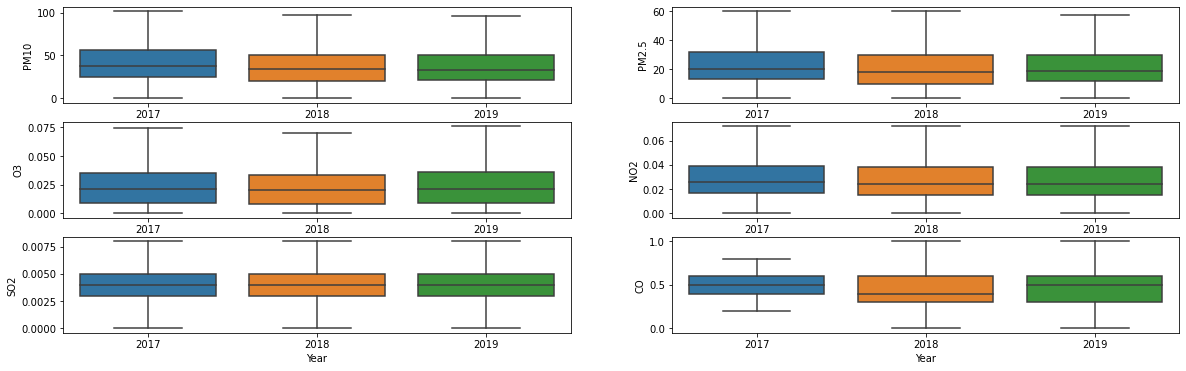

In [224]:
f, axes = plt.subplots(3, 2, figsize=(20, 6))
sns.boxplot(x='Year', y='PM10', data=df, showfliers=False,ax=axes[0][0])
sns.boxplot(x='Year', y='PM2.5', data=df, showfliers=False,ax=axes[0][1])
sns.boxplot(x='Year', y='O3', data=df, showfliers=False,ax=axes[1][0])
sns.boxplot(x='Year', y='NO2', data=df, showfliers=False,ax=axes[1][1])
sns.boxplot(x='Year', y='SO2', data=df, showfliers=False,ax=axes[2][0])
sns.boxplot(x='Year', y='CO', data=df, showfliers=False,ax=axes[2][1])

Plotting boxplots of the pollutants monthly

<AxesSubplot:xlabel='Month', ylabel='CO'>

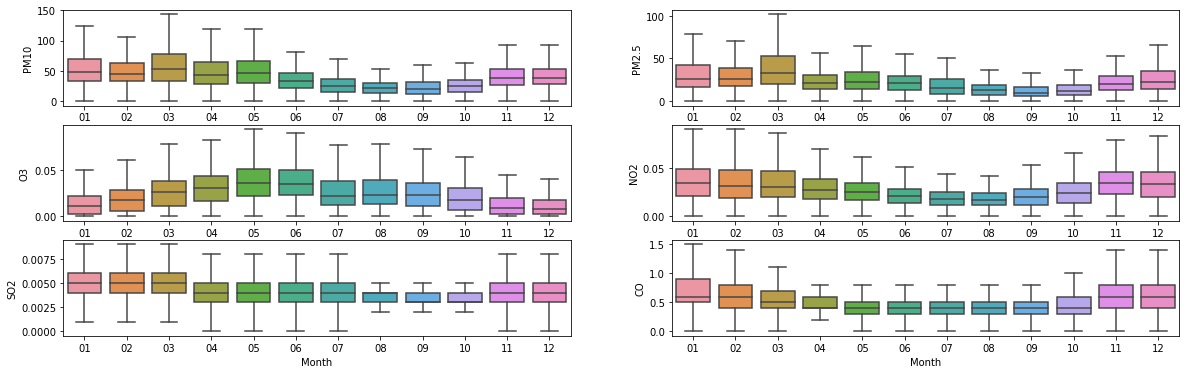

In [225]:
f, axes = plt.subplots(3, 2, figsize=(20, 6))
sns.boxplot(x='Month', y='PM10', data=df, showfliers=False,ax=axes[0][0])
sns.boxplot(x='Month', y='PM2.5', data=df, showfliers=False,ax=axes[0][1])
sns.boxplot(x='Month', y='O3', data=df, showfliers=False,ax=axes[1][0])
sns.boxplot(x='Month', y='NO2', data=df, showfliers=False,ax=axes[1][1])
sns.boxplot(x='Month', y='SO2', data=df, showfliers=False,ax=axes[2][0])
sns.boxplot(x='Month', y='CO', data=df, showfliers=False,ax=axes[2][1])

Plotting boxplots of the pollutants per station code

<AxesSubplot:xlabel='Station code', ylabel='CO'>

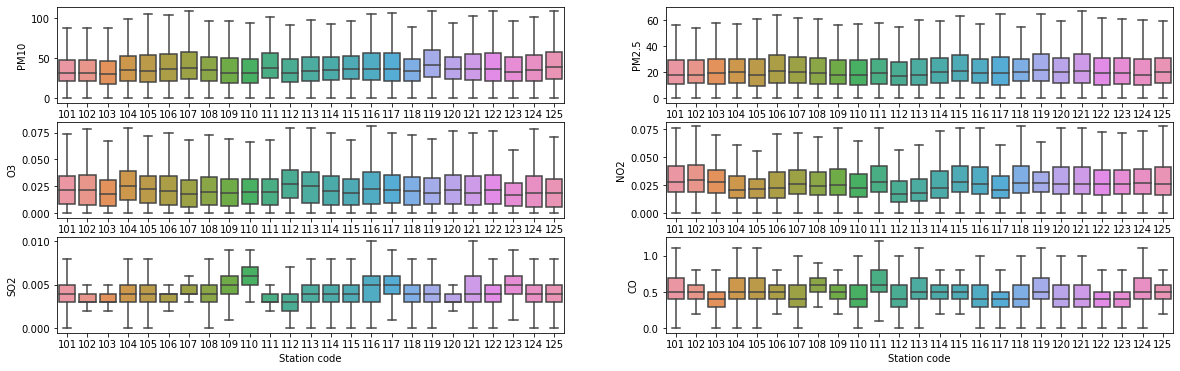

In [226]:
f, axes = plt.subplots(3, 2, figsize=(20, 6))
sns.boxplot(x='Station code', y='PM10', data=df, showfliers=False,ax=axes[0][0])
sns.boxplot(x='Station code', y='PM2.5', data=df, showfliers=False,ax=axes[0][1])
sns.boxplot(x='Station code', y='O3', data=df, showfliers=False,ax=axes[1][0])
sns.boxplot(x='Station code', y='NO2', data=df, showfliers=False,ax=axes[1][1])
sns.boxplot(x='Station code', y='SO2', data=df, showfliers=False,ax=axes[2][0])
sns.boxplot(x='Station code', y='CO', data=df, showfliers=False,ax=axes[2][1])

In [91]:
df.dtypes

Measurement date     object
Station code          int64
Address              object
Latitude            float64
Longitude           float64
SO2                 float64
NO2                 float64
O3                  float64
CO                  float64
PM10                float64
PM2.5               float64
Date                 object
Time                 object
Month                object
Year                 object
Day                  object
dtype: object

VIF Calculation

In [230]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = analyseData[['SO2', 'NO2','CO','PM10','PM2.5']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

  feature       VIF
0     SO2  3.095747
1     NO2  2.448343
2      CO  1.937606
3    PM10  1.411393
4   PM2.5  1.411941
